In [7]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

In [2]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "Month", "TRF", "Submitted_for_Approval", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [8]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy = "mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns = cols)

    return (data)

In [9]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [10]:
prep = preprocess(data, ada = True)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0)

In [12]:
model = xgb.XGBClassifier(learning_rate = 0.015, 
                          booster = 'gbtree',
                          objective = 'binary:logistic',
                          n_estimators = 5000)

In [13]:
model.fit(x_train.drop(target, axis = 1), 
          y_train, eval_metric = 'logloss', 
          eval_set=[(x_test.drop(target, axis = 1), y_test)], 
          early_stopping_rounds = 800)

[0]	validation_0-logloss:0.680434
Will train until validation_0-logloss hasn't improved in 800 rounds.
[1]	validation_0-logloss:0.668141
[2]	validation_0-logloss:0.656167
[3]	validation_0-logloss:0.644521
[4]	validation_0-logloss:0.633252
[5]	validation_0-logloss:0.622289
[6]	validation_0-logloss:0.611677
[7]	validation_0-logloss:0.601261
[8]	validation_0-logloss:0.591225
[9]	validation_0-logloss:0.581418
[10]	validation_0-logloss:0.571906
[11]	validation_0-logloss:0.562618
[12]	validation_0-logloss:0.553599
[13]	validation_0-logloss:0.544782
[14]	validation_0-logloss:0.536218
[15]	validation_0-logloss:0.527842
[16]	validation_0-logloss:0.51971
[17]	validation_0-logloss:0.511743
[18]	validation_0-logloss:0.504004
[19]	validation_0-logloss:0.496437
[20]	validation_0-logloss:0.489052
[21]	validation_0-logloss:0.48189
[22]	validation_0-logloss:0.474861
[23]	validation_0-logloss:0.467859
[24]	validation_0-logloss:0.461034
[25]	validation_0-logloss:0.454381
[26]	validation_0-logloss:0.44786

[230]	validation_0-logloss:0.1308
[231]	validation_0-logloss:0.130608
[232]	validation_0-logloss:0.130411
[233]	validation_0-logloss:0.130202
[234]	validation_0-logloss:0.130015
[235]	validation_0-logloss:0.129825
[236]	validation_0-logloss:0.129639
[237]	validation_0-logloss:0.129444
[238]	validation_0-logloss:0.129253
[239]	validation_0-logloss:0.129061
[240]	validation_0-logloss:0.128874
[241]	validation_0-logloss:0.128712
[242]	validation_0-logloss:0.128523
[243]	validation_0-logloss:0.128345
[244]	validation_0-logloss:0.128163
[245]	validation_0-logloss:0.127963
[246]	validation_0-logloss:0.127774
[247]	validation_0-logloss:0.127598
[248]	validation_0-logloss:0.127427
[249]	validation_0-logloss:0.127244
[250]	validation_0-logloss:0.126997
[251]	validation_0-logloss:0.126819
[252]	validation_0-logloss:0.126645
[253]	validation_0-logloss:0.126479
[254]	validation_0-logloss:0.126294
[255]	validation_0-logloss:0.126131
[256]	validation_0-logloss:0.125949
[257]	validation_0-logloss:0.1

[459]	validation_0-logloss:0.106635
[460]	validation_0-logloss:0.106584
[461]	validation_0-logloss:0.106538
[462]	validation_0-logloss:0.106421
[463]	validation_0-logloss:0.106397
[464]	validation_0-logloss:0.106342
[465]	validation_0-logloss:0.106297
[466]	validation_0-logloss:0.106288
[467]	validation_0-logloss:0.106231
[468]	validation_0-logloss:0.106152
[469]	validation_0-logloss:0.10607
[470]	validation_0-logloss:0.10605
[471]	validation_0-logloss:0.105935
[472]	validation_0-logloss:0.105919
[473]	validation_0-logloss:0.105875
[474]	validation_0-logloss:0.105822
[475]	validation_0-logloss:0.105714
[476]	validation_0-logloss:0.105634
[477]	validation_0-logloss:0.105626
[478]	validation_0-logloss:0.105519
[479]	validation_0-logloss:0.10544
[480]	validation_0-logloss:0.105328
[481]	validation_0-logloss:0.105324
[482]	validation_0-logloss:0.105283
[483]	validation_0-logloss:0.105262
[484]	validation_0-logloss:0.105178
[485]	validation_0-logloss:0.105101
[486]	validation_0-logloss:0.10

[688]	validation_0-logloss:0.096457
[689]	validation_0-logloss:0.096439
[690]	validation_0-logloss:0.096444
[691]	validation_0-logloss:0.096432
[692]	validation_0-logloss:0.096398
[693]	validation_0-logloss:0.096381
[694]	validation_0-logloss:0.096314
[695]	validation_0-logloss:0.096301
[696]	validation_0-logloss:0.096238
[697]	validation_0-logloss:0.096222
[698]	validation_0-logloss:0.096206
[699]	validation_0-logloss:0.096165
[700]	validation_0-logloss:0.09611
[701]	validation_0-logloss:0.096083
[702]	validation_0-logloss:0.096084
[703]	validation_0-logloss:0.09602
[704]	validation_0-logloss:0.095976
[705]	validation_0-logloss:0.095957
[706]	validation_0-logloss:0.095927
[707]	validation_0-logloss:0.095914
[708]	validation_0-logloss:0.095893
[709]	validation_0-logloss:0.095899
[710]	validation_0-logloss:0.095846
[711]	validation_0-logloss:0.095824
[712]	validation_0-logloss:0.095762
[713]	validation_0-logloss:0.095717
[714]	validation_0-logloss:0.095693
[715]	validation_0-logloss:0.0

[917]	validation_0-logloss:0.090395
[918]	validation_0-logloss:0.09038
[919]	validation_0-logloss:0.090366
[920]	validation_0-logloss:0.090348
[921]	validation_0-logloss:0.090353
[922]	validation_0-logloss:0.090327
[923]	validation_0-logloss:0.090322
[924]	validation_0-logloss:0.090314
[925]	validation_0-logloss:0.090287
[926]	validation_0-logloss:0.090269
[927]	validation_0-logloss:0.090249
[928]	validation_0-logloss:0.090246
[929]	validation_0-logloss:0.090225
[930]	validation_0-logloss:0.090204
[931]	validation_0-logloss:0.090195
[932]	validation_0-logloss:0.090168
[933]	validation_0-logloss:0.090155
[934]	validation_0-logloss:0.090104
[935]	validation_0-logloss:0.090099
[936]	validation_0-logloss:0.090104
[937]	validation_0-logloss:0.090081
[938]	validation_0-logloss:0.090051
[939]	validation_0-logloss:0.090036
[940]	validation_0-logloss:0.089999
[941]	validation_0-logloss:0.089984
[942]	validation_0-logloss:0.089967
[943]	validation_0-logloss:0.089941
[944]	validation_0-logloss:0.

[1142]	validation_0-logloss:0.086796
[1143]	validation_0-logloss:0.08677
[1144]	validation_0-logloss:0.086767
[1145]	validation_0-logloss:0.086766
[1146]	validation_0-logloss:0.086761
[1147]	validation_0-logloss:0.086763
[1148]	validation_0-logloss:0.086737
[1149]	validation_0-logloss:0.086736
[1150]	validation_0-logloss:0.086734
[1151]	validation_0-logloss:0.086716
[1152]	validation_0-logloss:0.086714
[1153]	validation_0-logloss:0.08672
[1154]	validation_0-logloss:0.086694
[1155]	validation_0-logloss:0.086686
[1156]	validation_0-logloss:0.086695
[1157]	validation_0-logloss:0.086674
[1158]	validation_0-logloss:0.086674
[1159]	validation_0-logloss:0.086657
[1160]	validation_0-logloss:0.086628
[1161]	validation_0-logloss:0.086621
[1162]	validation_0-logloss:0.086624
[1163]	validation_0-logloss:0.086614
[1164]	validation_0-logloss:0.086594
[1165]	validation_0-logloss:0.086588
[1166]	validation_0-logloss:0.086584
[1167]	validation_0-logloss:0.086576
[1168]	validation_0-logloss:0.08657
[116

[1365]	validation_0-logloss:0.084103
[1366]	validation_0-logloss:0.084088
[1367]	validation_0-logloss:0.084059
[1368]	validation_0-logloss:0.084069
[1369]	validation_0-logloss:0.084076
[1370]	validation_0-logloss:0.08405
[1371]	validation_0-logloss:0.084043
[1372]	validation_0-logloss:0.083985
[1373]	validation_0-logloss:0.083965
[1374]	validation_0-logloss:0.083954
[1375]	validation_0-logloss:0.083935
[1376]	validation_0-logloss:0.083919
[1377]	validation_0-logloss:0.083864
[1378]	validation_0-logloss:0.083858
[1379]	validation_0-logloss:0.083829
[1380]	validation_0-logloss:0.083819
[1381]	validation_0-logloss:0.083822
[1382]	validation_0-logloss:0.083806
[1383]	validation_0-logloss:0.083805
[1384]	validation_0-logloss:0.083797
[1385]	validation_0-logloss:0.083772
[1386]	validation_0-logloss:0.083771
[1387]	validation_0-logloss:0.083752
[1388]	validation_0-logloss:0.083745
[1389]	validation_0-logloss:0.083739
[1390]	validation_0-logloss:0.083736
[1391]	validation_0-logloss:0.083733
[1

[1588]	validation_0-logloss:0.081692
[1589]	validation_0-logloss:0.081666
[1590]	validation_0-logloss:0.081669
[1591]	validation_0-logloss:0.081654
[1592]	validation_0-logloss:0.08165
[1593]	validation_0-logloss:0.081657
[1594]	validation_0-logloss:0.081654
[1595]	validation_0-logloss:0.081644
[1596]	validation_0-logloss:0.08165
[1597]	validation_0-logloss:0.081654
[1598]	validation_0-logloss:0.081644
[1599]	validation_0-logloss:0.08165
[1600]	validation_0-logloss:0.081654
[1601]	validation_0-logloss:0.081646
[1602]	validation_0-logloss:0.081645
[1603]	validation_0-logloss:0.081642
[1604]	validation_0-logloss:0.081643
[1605]	validation_0-logloss:0.081625
[1606]	validation_0-logloss:0.081631
[1607]	validation_0-logloss:0.081625
[1608]	validation_0-logloss:0.081605
[1609]	validation_0-logloss:0.08158
[1610]	validation_0-logloss:0.081579
[1611]	validation_0-logloss:0.081566
[1612]	validation_0-logloss:0.081572
[1613]	validation_0-logloss:0.081566
[1614]	validation_0-logloss:0.081541
[1615

[1811]	validation_0-logloss:0.080306
[1812]	validation_0-logloss:0.080306
[1813]	validation_0-logloss:0.080287
[1814]	validation_0-logloss:0.080286
[1815]	validation_0-logloss:0.080282
[1816]	validation_0-logloss:0.080281
[1817]	validation_0-logloss:0.08027
[1818]	validation_0-logloss:0.08027
[1819]	validation_0-logloss:0.080259
[1820]	validation_0-logloss:0.080271
[1821]	validation_0-logloss:0.080269
[1822]	validation_0-logloss:0.080272
[1823]	validation_0-logloss:0.080271
[1824]	validation_0-logloss:0.080278
[1825]	validation_0-logloss:0.08026
[1826]	validation_0-logloss:0.080253
[1827]	validation_0-logloss:0.080242
[1828]	validation_0-logloss:0.080232
[1829]	validation_0-logloss:0.080227
[1830]	validation_0-logloss:0.080209
[1831]	validation_0-logloss:0.080184
[1832]	validation_0-logloss:0.080184
[1833]	validation_0-logloss:0.080191
[1834]	validation_0-logloss:0.080165
[1835]	validation_0-logloss:0.08015
[1836]	validation_0-logloss:0.080146
[1837]	validation_0-logloss:0.080142
[1838

[2033]	validation_0-logloss:0.079005
[2034]	validation_0-logloss:0.079018
[2035]	validation_0-logloss:0.079009
[2036]	validation_0-logloss:0.079004
[2037]	validation_0-logloss:0.079009
[2038]	validation_0-logloss:0.079
[2039]	validation_0-logloss:0.078967
[2040]	validation_0-logloss:0.078971
[2041]	validation_0-logloss:0.078972
[2042]	validation_0-logloss:0.078965
[2043]	validation_0-logloss:0.078961
[2044]	validation_0-logloss:0.078949
[2045]	validation_0-logloss:0.078948
[2046]	validation_0-logloss:0.078941
[2047]	validation_0-logloss:0.078942
[2048]	validation_0-logloss:0.078941
[2049]	validation_0-logloss:0.078927
[2050]	validation_0-logloss:0.078918
[2051]	validation_0-logloss:0.078914
[2052]	validation_0-logloss:0.078906
[2053]	validation_0-logloss:0.07891
[2054]	validation_0-logloss:0.078875
[2055]	validation_0-logloss:0.078868
[2056]	validation_0-logloss:0.078876
[2057]	validation_0-logloss:0.078853
[2058]	validation_0-logloss:0.078844
[2059]	validation_0-logloss:0.07884
[2060]

[2256]	validation_0-logloss:0.077933
[2257]	validation_0-logloss:0.077929
[2258]	validation_0-logloss:0.077925
[2259]	validation_0-logloss:0.077928
[2260]	validation_0-logloss:0.077929
[2261]	validation_0-logloss:0.077931
[2262]	validation_0-logloss:0.077926
[2263]	validation_0-logloss:0.07789
[2264]	validation_0-logloss:0.077874
[2265]	validation_0-logloss:0.077863
[2266]	validation_0-logloss:0.077863
[2267]	validation_0-logloss:0.07786
[2268]	validation_0-logloss:0.077864
[2269]	validation_0-logloss:0.077852
[2270]	validation_0-logloss:0.077851
[2271]	validation_0-logloss:0.077824
[2272]	validation_0-logloss:0.077833
[2273]	validation_0-logloss:0.07783
[2274]	validation_0-logloss:0.077828
[2275]	validation_0-logloss:0.07783
[2276]	validation_0-logloss:0.077827
[2277]	validation_0-logloss:0.077829
[2278]	validation_0-logloss:0.077824
[2279]	validation_0-logloss:0.077798
[2280]	validation_0-logloss:0.077798
[2281]	validation_0-logloss:0.077793
[2282]	validation_0-logloss:0.077792
[2283

[2478]	validation_0-logloss:0.076869
[2479]	validation_0-logloss:0.07687
[2480]	validation_0-logloss:0.076872
[2481]	validation_0-logloss:0.076862
[2482]	validation_0-logloss:0.07686
[2483]	validation_0-logloss:0.076858
[2484]	validation_0-logloss:0.076852
[2485]	validation_0-logloss:0.076855
[2486]	validation_0-logloss:0.076858
[2487]	validation_0-logloss:0.076842
[2488]	validation_0-logloss:0.07684
[2489]	validation_0-logloss:0.076837
[2490]	validation_0-logloss:0.076842
[2491]	validation_0-logloss:0.076845
[2492]	validation_0-logloss:0.076849
[2493]	validation_0-logloss:0.076844
[2494]	validation_0-logloss:0.076836
[2495]	validation_0-logloss:0.076804
[2496]	validation_0-logloss:0.076794
[2497]	validation_0-logloss:0.07679
[2498]	validation_0-logloss:0.076767
[2499]	validation_0-logloss:0.076745
[2500]	validation_0-logloss:0.076735
[2501]	validation_0-logloss:0.076741
[2502]	validation_0-logloss:0.07672
[2503]	validation_0-logloss:0.076713
[2504]	validation_0-logloss:0.076716
[2505]

[2701]	validation_0-logloss:0.075936
[2702]	validation_0-logloss:0.075938
[2703]	validation_0-logloss:0.075943
[2704]	validation_0-logloss:0.075952
[2705]	validation_0-logloss:0.075954
[2706]	validation_0-logloss:0.075959
[2707]	validation_0-logloss:0.075955
[2708]	validation_0-logloss:0.075955
[2709]	validation_0-logloss:0.075958
[2710]	validation_0-logloss:0.075947
[2711]	validation_0-logloss:0.07595
[2712]	validation_0-logloss:0.075937
[2713]	validation_0-logloss:0.075941
[2714]	validation_0-logloss:0.075937
[2715]	validation_0-logloss:0.075936
[2716]	validation_0-logloss:0.075931
[2717]	validation_0-logloss:0.075929
[2718]	validation_0-logloss:0.075923
[2719]	validation_0-logloss:0.075936
[2720]	validation_0-logloss:0.075944
[2721]	validation_0-logloss:0.07595
[2722]	validation_0-logloss:0.075947
[2723]	validation_0-logloss:0.07595
[2724]	validation_0-logloss:0.075955
[2725]	validation_0-logloss:0.075946
[2726]	validation_0-logloss:0.07594
[2727]	validation_0-logloss:0.075928
[2728

[2924]	validation_0-logloss:0.075361
[2925]	validation_0-logloss:0.075343
[2926]	validation_0-logloss:0.075342
[2927]	validation_0-logloss:0.075345
[2928]	validation_0-logloss:0.075347
[2929]	validation_0-logloss:0.07535
[2930]	validation_0-logloss:0.075354
[2931]	validation_0-logloss:0.075339
[2932]	validation_0-logloss:0.075339
[2933]	validation_0-logloss:0.075331
[2934]	validation_0-logloss:0.075328
[2935]	validation_0-logloss:0.075318
[2936]	validation_0-logloss:0.075325
[2937]	validation_0-logloss:0.075314
[2938]	validation_0-logloss:0.075313
[2939]	validation_0-logloss:0.075312
[2940]	validation_0-logloss:0.075313
[2941]	validation_0-logloss:0.075314
[2942]	validation_0-logloss:0.07531
[2943]	validation_0-logloss:0.075312
[2944]	validation_0-logloss:0.075315
[2945]	validation_0-logloss:0.075311
[2946]	validation_0-logloss:0.075317
[2947]	validation_0-logloss:0.075309
[2948]	validation_0-logloss:0.075293
[2949]	validation_0-logloss:0.075294
[2950]	validation_0-logloss:0.075301
[29

[3147]	validation_0-logloss:0.074901
[3148]	validation_0-logloss:0.074897
[3149]	validation_0-logloss:0.074895
[3150]	validation_0-logloss:0.074886
[3151]	validation_0-logloss:0.074888
[3152]	validation_0-logloss:0.074867
[3153]	validation_0-logloss:0.074866
[3154]	validation_0-logloss:0.074866
[3155]	validation_0-logloss:0.074866
[3156]	validation_0-logloss:0.074854
[3157]	validation_0-logloss:0.074854
[3158]	validation_0-logloss:0.074853
[3159]	validation_0-logloss:0.074843
[3160]	validation_0-logloss:0.074837
[3161]	validation_0-logloss:0.074838
[3162]	validation_0-logloss:0.074831
[3163]	validation_0-logloss:0.074832
[3164]	validation_0-logloss:0.074833
[3165]	validation_0-logloss:0.074833
[3166]	validation_0-logloss:0.074831
[3167]	validation_0-logloss:0.074842
[3168]	validation_0-logloss:0.074835
[3169]	validation_0-logloss:0.074832
[3170]	validation_0-logloss:0.074839
[3171]	validation_0-logloss:0.07485
[3172]	validation_0-logloss:0.074838
[3173]	validation_0-logloss:0.074817
[3

[3369]	validation_0-logloss:0.074238
[3370]	validation_0-logloss:0.074231
[3371]	validation_0-logloss:0.074228
[3372]	validation_0-logloss:0.074208
[3373]	validation_0-logloss:0.074207
[3374]	validation_0-logloss:0.074211
[3375]	validation_0-logloss:0.074197
[3376]	validation_0-logloss:0.074199
[3377]	validation_0-logloss:0.074213
[3378]	validation_0-logloss:0.074212
[3379]	validation_0-logloss:0.074208
[3380]	validation_0-logloss:0.074186
[3381]	validation_0-logloss:0.074186
[3382]	validation_0-logloss:0.074183
[3383]	validation_0-logloss:0.074182
[3384]	validation_0-logloss:0.074181
[3385]	validation_0-logloss:0.074195
[3386]	validation_0-logloss:0.074174
[3387]	validation_0-logloss:0.074171
[3388]	validation_0-logloss:0.074164
[3389]	validation_0-logloss:0.074158
[3390]	validation_0-logloss:0.074161
[3391]	validation_0-logloss:0.074162
[3392]	validation_0-logloss:0.074155
[3393]	validation_0-logloss:0.074158
[3394]	validation_0-logloss:0.074157
[3395]	validation_0-logloss:0.07416
[3

[3592]	validation_0-logloss:0.073561
[3593]	validation_0-logloss:0.073555
[3594]	validation_0-logloss:0.07355
[3595]	validation_0-logloss:0.07355
[3596]	validation_0-logloss:0.073552
[3597]	validation_0-logloss:0.07355
[3598]	validation_0-logloss:0.073542
[3599]	validation_0-logloss:0.073533
[3600]	validation_0-logloss:0.073529
[3601]	validation_0-logloss:0.073522
[3602]	validation_0-logloss:0.073517
[3603]	validation_0-logloss:0.073517
[3604]	validation_0-logloss:0.073511
[3605]	validation_0-logloss:0.073505
[3606]	validation_0-logloss:0.073499
[3607]	validation_0-logloss:0.073493
[3608]	validation_0-logloss:0.073495
[3609]	validation_0-logloss:0.073501
[3610]	validation_0-logloss:0.073482
[3611]	validation_0-logloss:0.073468
[3612]	validation_0-logloss:0.073473
[3613]	validation_0-logloss:0.073469
[3614]	validation_0-logloss:0.073465
[3615]	validation_0-logloss:0.073465
[3616]	validation_0-logloss:0.073466
[3617]	validation_0-logloss:0.073451
[3618]	validation_0-logloss:0.073441
[361

[3814]	validation_0-logloss:0.072982
[3815]	validation_0-logloss:0.07298
[3816]	validation_0-logloss:0.072982
[3817]	validation_0-logloss:0.072967
[3818]	validation_0-logloss:0.072963
[3819]	validation_0-logloss:0.072954
[3820]	validation_0-logloss:0.072956
[3821]	validation_0-logloss:0.072961
[3822]	validation_0-logloss:0.072963
[3823]	validation_0-logloss:0.072949
[3824]	validation_0-logloss:0.072954
[3825]	validation_0-logloss:0.072951
[3826]	validation_0-logloss:0.07294
[3827]	validation_0-logloss:0.072938
[3828]	validation_0-logloss:0.072935
[3829]	validation_0-logloss:0.072926
[3830]	validation_0-logloss:0.072932
[3831]	validation_0-logloss:0.072932
[3832]	validation_0-logloss:0.072937
[3833]	validation_0-logloss:0.072942
[3834]	validation_0-logloss:0.072934
[3835]	validation_0-logloss:0.072931
[3836]	validation_0-logloss:0.072939
[3837]	validation_0-logloss:0.072946
[3838]	validation_0-logloss:0.072951
[3839]	validation_0-logloss:0.072949
[3840]	validation_0-logloss:0.072937
[38

[4037]	validation_0-logloss:0.072357
[4038]	validation_0-logloss:0.072354
[4039]	validation_0-logloss:0.072358
[4040]	validation_0-logloss:0.072343
[4041]	validation_0-logloss:0.072326
[4042]	validation_0-logloss:0.072317
[4043]	validation_0-logloss:0.072308
[4044]	validation_0-logloss:0.072306
[4045]	validation_0-logloss:0.072309
[4046]	validation_0-logloss:0.072305
[4047]	validation_0-logloss:0.072298
[4048]	validation_0-logloss:0.07229
[4049]	validation_0-logloss:0.0723
[4050]	validation_0-logloss:0.072301
[4051]	validation_0-logloss:0.072291
[4052]	validation_0-logloss:0.072292
[4053]	validation_0-logloss:0.072295
[4054]	validation_0-logloss:0.072296
[4055]	validation_0-logloss:0.072294
[4056]	validation_0-logloss:0.072296
[4057]	validation_0-logloss:0.072287
[4058]	validation_0-logloss:0.072274
[4059]	validation_0-logloss:0.072276
[4060]	validation_0-logloss:0.072269
[4061]	validation_0-logloss:0.072251
[4062]	validation_0-logloss:0.072253
[4063]	validation_0-logloss:0.072255
[406

[4260]	validation_0-logloss:0.07165
[4261]	validation_0-logloss:0.071643
[4262]	validation_0-logloss:0.071645
[4263]	validation_0-logloss:0.07163
[4264]	validation_0-logloss:0.071632
[4265]	validation_0-logloss:0.071633
[4266]	validation_0-logloss:0.071633
[4267]	validation_0-logloss:0.071636
[4268]	validation_0-logloss:0.07164
[4269]	validation_0-logloss:0.071631
[4270]	validation_0-logloss:0.071628
[4271]	validation_0-logloss:0.07162
[4272]	validation_0-logloss:0.071629
[4273]	validation_0-logloss:0.071629
[4274]	validation_0-logloss:0.071635
[4275]	validation_0-logloss:0.071636
[4276]	validation_0-logloss:0.071643
[4277]	validation_0-logloss:0.071628
[4278]	validation_0-logloss:0.071617
[4279]	validation_0-logloss:0.071612
[4280]	validation_0-logloss:0.071605
[4281]	validation_0-logloss:0.071604
[4282]	validation_0-logloss:0.071597
[4283]	validation_0-logloss:0.071597
[4284]	validation_0-logloss:0.0716
[4285]	validation_0-logloss:0.071598
[4286]	validation_0-logloss:0.0716
[4287]	va

[4483]	validation_0-logloss:0.071485
[4484]	validation_0-logloss:0.071482
[4485]	validation_0-logloss:0.071489
[4486]	validation_0-logloss:0.071485
[4487]	validation_0-logloss:0.071491
[4488]	validation_0-logloss:0.071498
[4489]	validation_0-logloss:0.07149
[4490]	validation_0-logloss:0.071481
[4491]	validation_0-logloss:0.071491
[4492]	validation_0-logloss:0.071491
[4493]	validation_0-logloss:0.071499
[4494]	validation_0-logloss:0.071484
[4495]	validation_0-logloss:0.071487
[4496]	validation_0-logloss:0.071487
[4497]	validation_0-logloss:0.071486
[4498]	validation_0-logloss:0.071478
[4499]	validation_0-logloss:0.071486
[4500]	validation_0-logloss:0.071478
[4501]	validation_0-logloss:0.071477
[4502]	validation_0-logloss:0.071474
[4503]	validation_0-logloss:0.071463
[4504]	validation_0-logloss:0.071448
[4505]	validation_0-logloss:0.071445
[4506]	validation_0-logloss:0.071434
[4507]	validation_0-logloss:0.07144
[4508]	validation_0-logloss:0.071439
[4509]	validation_0-logloss:0.071424
[45

[4705]	validation_0-logloss:0.071164
[4706]	validation_0-logloss:0.071167
[4707]	validation_0-logloss:0.07117
[4708]	validation_0-logloss:0.071177
[4709]	validation_0-logloss:0.07117
[4710]	validation_0-logloss:0.071171
[4711]	validation_0-logloss:0.071162
[4712]	validation_0-logloss:0.071155
[4713]	validation_0-logloss:0.071161
[4714]	validation_0-logloss:0.071151
[4715]	validation_0-logloss:0.071156
[4716]	validation_0-logloss:0.071162
[4717]	validation_0-logloss:0.071165
[4718]	validation_0-logloss:0.071166
[4719]	validation_0-logloss:0.07117
[4720]	validation_0-logloss:0.071165
[4721]	validation_0-logloss:0.071172
[4722]	validation_0-logloss:0.071169
[4723]	validation_0-logloss:0.071175
[4724]	validation_0-logloss:0.071168
[4725]	validation_0-logloss:0.071175
[4726]	validation_0-logloss:0.071173
[4727]	validation_0-logloss:0.071171
[4728]	validation_0-logloss:0.071163
[4729]	validation_0-logloss:0.071173
[4730]	validation_0-logloss:0.071169
[4731]	validation_0-logloss:0.071168
[473

[4928]	validation_0-logloss:0.070911
[4929]	validation_0-logloss:0.070909
[4930]	validation_0-logloss:0.070908
[4931]	validation_0-logloss:0.070911
[4932]	validation_0-logloss:0.070902
[4933]	validation_0-logloss:0.070901
[4934]	validation_0-logloss:0.070895
[4935]	validation_0-logloss:0.070895
[4936]	validation_0-logloss:0.070883
[4937]	validation_0-logloss:0.070884
[4938]	validation_0-logloss:0.070884
[4939]	validation_0-logloss:0.07089
[4940]	validation_0-logloss:0.070888
[4941]	validation_0-logloss:0.070882
[4942]	validation_0-logloss:0.070888
[4943]	validation_0-logloss:0.070891
[4944]	validation_0-logloss:0.070898
[4945]	validation_0-logloss:0.070893
[4946]	validation_0-logloss:0.070892
[4947]	validation_0-logloss:0.070895
[4948]	validation_0-logloss:0.070889
[4949]	validation_0-logloss:0.070896
[4950]	validation_0-logloss:0.070897
[4951]	validation_0-logloss:0.070896
[4952]	validation_0-logloss:0.070892
[4953]	validation_0-logloss:0.070889
[4954]	validation_0-logloss:0.070891
[4

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.015, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [14]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [15]:
x_test.Stage.head(10)

2040     0.0
4069     0.0
4230     1.0
578      1.0
12594    0.0
6042     1.0
2763     0.0
15900    0.0
2669     1.0
12802    0.0
Name: Stage, dtype: float64

In [16]:
res = y_pred[:,1]

In [17]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [18]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [19]:
log_loss(answer["Stage"], answer["Prediction"])

0.08004333611411328

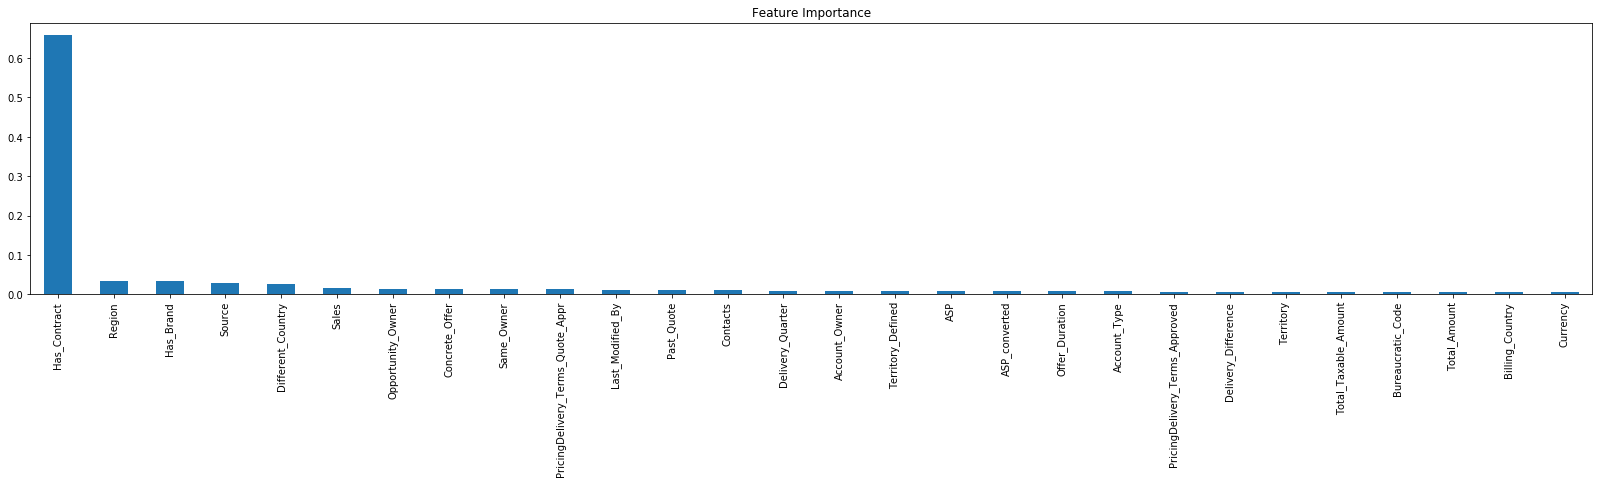

In [21]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [27]:
print feat_imp

Has_Contract                        0.657529
Region                              0.034324
Has_Brand                           0.033923
Source                              0.028535
Different_Country                   0.025642
Sales                               0.016454
Opportunity_Owner                   0.014760
Concrete_Offer                      0.013943
Same_Owner                          0.013432
PricingDelivery_Terms_Quote_Appr    0.013247
Last_Modified_By                    0.010649
Past_Quote                          0.010544
Contacts                            0.010038
Delivery_Quarter                    0.009498
Account_Owner                       0.008366
Territory_Defined                   0.008138
ASP                                 0.008007
ASP_converted                       0.007906
Offer_Duration                      0.007404
Account_Type                        0.007347
PricingDelivery_Terms_Approved      0.007146
Delivery_Difference                 0.006990
Territory 

In [22]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali, ada = True)

In [23]:
validation.head()

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Territory_Defined,Past_Quote
0,2.0,14.0,1.0,1.0,1.0,1.0,3.0,10.0,12.0,10689.0,725.0,0.0,0.0,0.0,1.0,1.0,0.325,0.36761,1.0,162240.0,367419.0,3.0,30.0,1.0,0.0,1.0,0.0,0.0,30.0,49.0,18.0,1.0,-18.0
1,2.0,14.0,1.0,1.0,1.0,1.0,3.0,10.0,12.0,10689.0,725.0,0.0,0.0,0.0,1.0,1.0,0.320,0.36195,1.0,78624.0,367419.0,3.0,30.0,1.0,0.0,1.0,0.0,0.0,30.0,49.0,18.0,1.0,-18.0
2,2.0,14.0,1.0,1.0,1.0,1.0,3.0,10.0,12.0,10689.0,725.0,0.0,0.0,0.0,1.0,1.0,0.275,0.31105,1.0,126555.0,367419.0,3.0,30.0,1.0,0.0,1.0,0.0,0.0,30.0,49.0,18.0,1.0,-18.0
3,2.0,14.0,1.0,1.0,1.0,1.0,3.0,10.0,12.0,10690.0,788.0,0.0,0.0,0.0,1.0,1.0,0.325,0.36761,1.0,243360.0,757783.5,5.0,27.0,1.0,0.0,1.0,0.0,1.0,30.0,77.0,18.0,1.0,-5.0
4,2.0,14.0,1.0,1.0,1.0,1.0,3.0,10.0,12.0,10690.0,788.0,0.0,0.0,0.0,1.0,1.0,0.320,0.36195,1.0,157248.0,757783.5,5.0,28.0,1.0,0.0,1.0,0.0,0.0,30.0,78.0,18.0,1.0,-5.0


In [24]:
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))

In [25]:
pred_vali = pred[:,1]

In [26]:
pred = pd.DataFrame(pred_vali, index = validation.index, columns = ["Prediction"])
pred_vali = validation.join(pred)

In [28]:
answer = pd.DataFrame(pred_vali.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [37]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9885722047297949

In [38]:
answer.to_csv("best/model_xgboost_pred.csv", index = False, header = False)

In [94]:
model.fit(prep.drop(target, axis=1), 
          prep.Stage, eval_metric='logloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.015, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [96]:
y_pred_full = model.predict_proba(prep.drop(target, axis=1))
y_pred_full = y_pred_full[:,1]

In [102]:
pred = pd.DataFrame(y_pred_full, index = prep.index, columns = ["Prediction"])

In [104]:
pred_full = prep.join(pred)
answer_full = pred_full.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [106]:
log_loss(answer_full["Stage"], answer_full["Prediction"])

0.05342313995799043

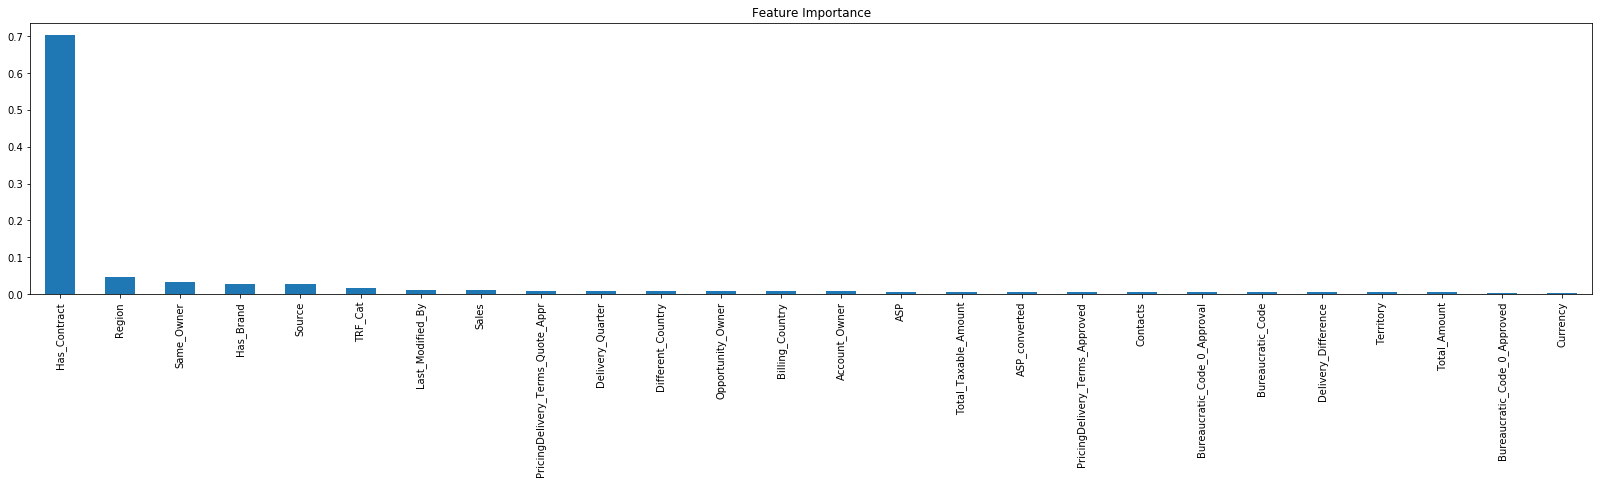

In [108]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')